# Esonero 2 - 17 Maggio 2021

Completare i seguenti esercizi tramite uno o più blocchi di codice descrivendo le operazioni effettuate


In [1]:
import cv2
import skimage
import numpy as np
import scipy.ndimage as ndimage
from scipy.ndimage import convolve, correlate, filters
import matplotlib.pyplot as plt

%matplotlib inline


def load_rgb(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)


def load_gray(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)


def rgb_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def pgray(image, title=None, figsize=None):
    if not figsize is None:
        plt.figure(figsize=figsize)
    
    if not title is None:
        plt.title(title)

    plt.imshow(image, cmap="gray")
    plt.show()

    
def prgb(image, title=None, figsize=None):
    if not figsize is None:
        plt.figure(figsize=figsize)
    
    if not title is None:
        plt.title(title)

    plt.imshow(image, cmap="gray")
    plt.show()
    


# Esercizio 1

Data la seguente immagine, costruire la feature pyramid di gaussiane e descrivere il procedimento

![](figure1.jpg)

Il processo consiste nel simulare la perdita di dettagli che si otterrebbe se si guardasse l'immagine da prospettive via via più lontane.  

Di fatto si ha una perdita di dettagli che fa mettere in risalto i keypoints più essenziali.  

L'idea deriva da una proprieta del filtro gaussiano: g_s(g_s(img)) = g_2s(img), alcuni pixel perono dettagli e diventano inutili per cui si fa sub sampling.  L'immagine passa da h*w ad h//2*w//2.  

L'implementazione sfrutta in più il principio lo scaleSpace (ovvero la rappresentazione di un immagine come una famiglia di versione smoothed della stessa) e delle ottave che consiste nel passare da  g_s(g_s(img)) a g_2s(img) progressivamente.

In [2]:
source = load_rgb("figure1.jpg")

In [3]:
image = skimage.img_as_float32(rgb_to_gray(source.copy()))

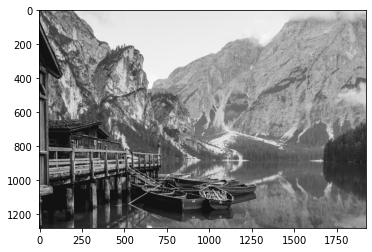

In [4]:
pgray(image)

In [5]:
def generate_octave(init_level, s, sigma): 
    octave = [init_level] 
    k = 2**(1/s) 
    for _ in range(s+2): 
        next_level = ndimage.gaussian_filter(octave[-1],k * sigma)
        octave.append(next_level) 
    return octave

def generate_gaussian_pyramid(im, num_octave, s, sigma): 
    pyr = [] 
    for _ in range(num_octave): 
        octave = generate_octave(im, s, sigma) 
        pyr.append(octave) 
        im = octave[-3][::2, ::2] 
    return pyr

In [6]:
def plot_pyramid(p,sz,hspace=10,vspace=10):
    rows, cols = sz[0],sz[1]

    nrows = sum([x[0].shape[0] for x in p]) +  vspace*(num_octave-1)
    ncols = cols*(s+3)+hspace*(s+2)
    output_image = np.ones((nrows,ncols))

    r = 0
    for i in range(len(p)):
        c = 0
        for j in range(len(p[i])):
            w,h = p[i][j].shape
            output_image[r:r+w,c:c+h] = p[i][j]
            c += cols + hspace
        r += w + vspace
    
    return output_image

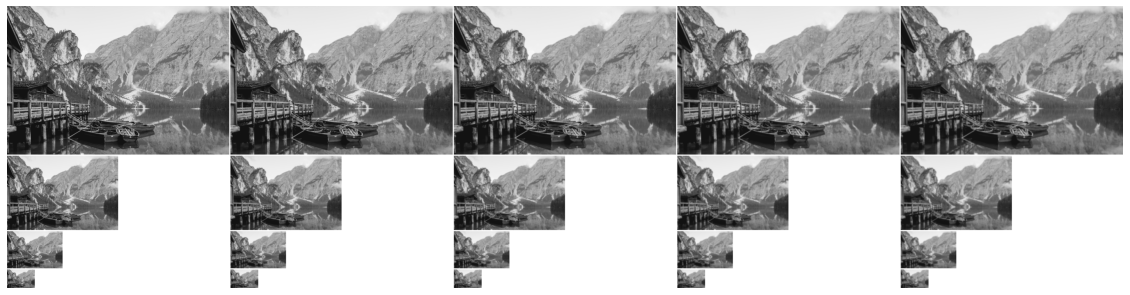

In [7]:
num_octave = 4
s = 2
sigma = 1

p = generate_gaussian_pyramid(image,num_octave,s,sigma)

output_pyr = plot_pyramid(p,image.shape)

fig = plt.figure(figsize=(20, 20))

plt.imshow(output_pyr,cmap="gray")
plt.axis('off')
plt.show()

Lo scale space appena mostrato è in due dimensioni: 
- lungo le colonne, le immagini viene convolute iterativamente con un filtro gaussiano di devianza $k\sigma$, dove k = 2**(1/s), s=2. 
- Ogni riga inizia con la terz'ultima immagine della riga precedente ovvero quando sigma=2*sigma, campionata al 50%.

# Esercizio 2


Data la seguente sequenza di tensori e la funzione *f*, calcolare il gradiente per i tensori a,b,c,d,e,y. 

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita. 

$
y = f(a,b,c,d,e) = \sum \frac {a^3 + \exp(b^5) * \sin (c*d)} {3e}
$

*non sono necessarie librerie esterne*

In [8]:
import torch
import numpy as np
import torch.nn as nn
import torchvision

In [9]:
a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
a.retain_grad()
b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b.retain_grad()
c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
c.retain_grad()
d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
d.retain_grad()
e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e.retain_grad()

y = ((a ** 3) + torch.exp(b ** 5) * torch.sin(c * d) / (3 * e))
y.sum().backward()

In [10]:
a.grad

tensor([[ 75., 108.],
        [147., 192.],
        [  3.,  12.]])

In [11]:
b.grad

tensor([[        inf,        -inf],
        [ 0.0000e+00, -2.3629e+00],
        [       -inf,  2.9715e+14]])

In [12]:
c.grad

tensor([[       -inf,         inf],
        [ 1.0000e+00,  6.1848e+00],
        [        inf, -2.6058e+13]])

In [13]:
d.grad

tensor([[       -inf,         inf],
        [ 0.0000e+00,  5.4117e+00],
        [        inf, -7.8173e+13]])

# Esercizio 3

Dati due batch A e B, mostrare gli effetti della BN.

Suggerimento: calcolare gli istogrammi di A e B

In [14]:
import random
a = []
for i in range(256):
    tensor = torch.ones((1, 3, 200, 200)) * 10
    a.append(tensor)

b = []
for i in range(256):
    tensor = torch.ones((1, 3, 200, 200)) * 100
    b.append(tensor)

In [15]:
no_bach = nn.Sequential(
    nn.Conv2d(1, 3, 11),
    nn.ReLU()
)

In [16]:
bach = nn.Sequential(
    nn.Conv2d(1, 3, 11),
    nn.ReLU(),
    nn.BatchNorm2d(3)
)

In [17]:
outputs_np_bach = []
for i in range(256):
    outputs_np_bach.append(a[i])
    outputs_np_bach.append(b[i])

In [18]:
max_ = -199
for i in range(512):
    tmp = torch.max(outputs_np_bach[i])
    max_ = max(tmp.item(), max_)

print(max_)

100.0


In [19]:
outputs_bach = []
for i in range(512):
    outputs_np_bach.append(a[i])
    outputs_bach.append(b[i])

IndexError: list index out of range

In [ ]:
max_ = -199
for i in range(256):
    tmp = torch.max(outputs_bach[i])
    max_ = max(tmp.item(), max_)

print(max_)

# Esercizio 4

Dato il seguente frammento di codice

In [ ]:
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

model = lambda x: conv2(conv1(x))

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio. 

Si applicano in cascata il modulo con1 e dopo il modulo conv2. 
conv1 avendo k_size = 3 farebbe perdere 1 pixel per ogni dimensione, avendo aggiunto padding 1 questo effetti viene mitigato.
Il modulo applica inoltre stride = 2 => l'immagine sarà dimezzata. Dopo conv1 avremo  1x3x200x200

In [ ]:
sample1 = torch.ones(1, 3, 400, 400)

In [ ]:
conv1(sample1).shape

Per quanto converne conv2, questo lavoro sull'output di conv1 => (1, 10, 200, 200).
Si utilizzano questa volta un kernel (3, 5),  padding=(0, 1), stride=(3, 4), per il calcolo si puo usare la formula della convoluzione.

In [ ]:
kernel = (3, 5)
stride = (3, 4)
padding = (0, 1)
dilation = (1, 1) #default di nn.Conv
h = 200
w = 200

In [ ]:
import math
h = h + 2 * padding[0] - dilation[0] * (kernel[0] - 1) - 1
h = h / stride[0]
h = math.floor(h + 1)

w = w + 2 * padding[1] - dilation[1] * (kernel[1] - 1) - 1
w = w / stride[1]
w = math.floor(w + 1)

In [ ]:
print(h, w)

In [ ]:
sample2 = torch.ones(1, 10, 200, 200)
conv2(sample2).shape

In [ ]:
ouput = model(sample1)
ouput.shape

# Esercizio 5

Adattare/semplificare la rete AlexNet affinché gestisca un input di immagini 400x400

In [ ]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), 
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
        
        # Edit per capire da dove deriva cio che ho fatto guardare prima sotto
        
        resize_convs = []
        
        for i in range(17):
             resize_convs.append(nn.Conv2d(3, 3, 11))
        
        # applicando le 17 conv 11*11 la shape è 230x230
        
        # applicando un filtro 8*8 e padding=1 che mi fa perdere 3 pixel per dimensione, la size è pronta per la Alexnet 227*227
        
        resize_convs.append(nn.Conv2d(3, 3, 8, padding=2))
        
        self.resize = nn.Sequential(*resize_convs)
        
        # End Edit
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, x):
        # Edit
        x = self.resize(x)
        print(x.shape)
        #End Edit
        
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        
        print(x.size())
        x = x.view(-1, 6*6*256)
        x = self.layer8(self.layer7(self.layer6(x)))
        
        return x

In [ ]:
sample = torch.ones(1,1,400,400)

In [ ]:
nn.Conv2d(1, 1, 11)(sample).shape

In [ ]:
for i in range(17):
    sample = nn.Conv2d(1, 1, 11)(sample)
    print(i, sample.shape)

In [ ]:
tmp = sample.clone()

In [ ]:
tmp.shape

In [ ]:
tmp_ = tmp
for i in range(5):
    tmp_ = nn.Conv2d(1, 1, 8, padding=2)(tmp_)
    print(tmp_.shape)

In [ ]:
sample = torch.ones(1,3,400,400)

In [ ]:
alex_net = AlexNet()

In [ ]:
alex_net.resize(sample)

# Esercizio 6

Data la seguente immagine, costruire due Bounding box con IoU = 0.5. 
Descrivere tutte le operazioni effettuate

![](figure2.jpg)

In [ ]:
image_bird = load_gray("figure2.jpg")
image_bird = image_bird.copy()

In [ ]:
image_bird.shape

In [ ]:
# Per semplicita' calcolo gli anchor box per il pixel 0, 0
# Le altre anchor box saranno ottenute come shift rispetto al punto 0, 0
def generate_anchor_base(sub_sample=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    
    py = sub_sample / 2
    px = sub_sample / 2

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)

    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            
            h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
            w = sub_sample * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            # [y_min, x_min, y_max, x_max]
            anchor_base[index, 0] = py - h / 2
            anchor_base[index, 1] = px - w / 2
            anchor_base[index, 2] = py + h / 2
            anchor_base[index, 3] = px + w / 2
            
    return anchor_base

In [ ]:
anchor_base = generate_anchor_base()

In [ ]:
def generate_anchor_box_by_pixel(anchor):
    py = anchor[0]
    px = anchor[1]
    anchor_base = generate_anchor_base()
    offset = np.array([py, px, py, px] * 9).reshape(9, 4)
    return offset + anchor_base

In [ ]:
def generate_anchors(h, w, subsample):
    shift_x = np.arange(0, h, sub_sample)  # stride=16
    shift_y = np.arange(0, w, sub_sample)
    
    anchors = []
    for x in shift_x:
        for y in shift_y:
            anchors.append((y, x))

    return np.asarray(anchors)

In [ ]:
def generate_anchor_boxes(anchors):
    anchor_boxes = []
    for anchor in anchors:
        anchor_boxes.append(generate_anchor_box_by_pixel(anchor))
    return np.asarray(anchor_boxes)

In [ ]:
sub_sample = 16
h, w = image_bird.shape[: 2]
shift_x = np.arange(0, w, sub_sample)  # stride=16
shift_y = np.arange(0, h, sub_sample)

In [ ]:
anchors = []
for x in shift_x:
    for y in shift_y:
        anchors.append((y, x))

In [ ]:
len(anchors)

In [ ]:
anchor_boxes = generate_anchor_boxes(anchors)

In [ ]:
anchor_boxes.shape

In [ ]:
def filter_inside_image_anchor_boxes(anchor_boxes, h, w):
    flattened = anchor_boxes.reshape(-1, 4)

    valid_indexes = np.where(
                            (flattened[:, 0] >= 0) &
                            (flattened[:, 1] >= 0) &
                            (flattened[:, 2] <= w) &
                            (flattened[:, 3] <= h)
                        )[0]
    return flattened[valid_indexes]

In [ ]:
valid_anchor_boxes = filter_inside_image_anchor_boxes(anchor_boxes, h, w)

In [ ]:
valid_anchor_boxes.shape # rimosse le anchor fuori immagine

In [ ]:
def compute_iou_scores(ground_truth, anchor_boxes):
    iou_scores = np.zeros((len(anchor_boxes), ground_truth.shape[0]), dtype=np.float32)

    for anchor_box_index, anchor_box in enumerate(anchor_boxes):
        ya1, xa1, ya2, xa2 = anchor_box
        anchor_area = (ya2 - ya1) * (xa2 - xa1)

        for truth_index, ground_truth_box in enumerate(ground_truth):
            yb1, xb1, yb2, xb2 = ground_truth_box
            box_area = (yb2 - yb1) * (xb2 - xb1)

            inter_x1 = max(xb1, xa1)
            inter_y1 = max(yb1, ya1)
            inter_x2 = min(xb2, xa2)
            inter_y2 = min(yb2, ya2)

            if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
                iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
                iou = iter_area / (anchor_area + box_area - iter_area)

                iou_scores[anchor_box_index, truth_index] = iou
    
    return iou_scores


In [ ]:
import matplotlib.patches as patches

def plot_bbox(image_tensor, bbox_list):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8, 8)

    ax.imshow(image_tensor)

    for bbox_idx in range(bbox_list.shape[0]):
        x1, y1, x2, y2 = bbox_list[bbox_idx, :].tolist()

        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

        ax.add_patch(rect)

    plt.show()
    


In [ ]:
bound_boxes = np.asarray([[0, 0, 200, 200], [100, 100, 400, 400]], dtype=np.float32)

In [ ]:
plot_bbox(image_bird, bound_boxes)

In [ ]:
box1 = bound_boxes[0]
box2 = bound_boxes[1]

In [ ]:
intersection = np.logical_and(box1, box2)
union = np.logical_or(box1,box2)
iou_score = np.sum(intersection) / np.sum(union)

In [ ]:
iou_score

Intersection over Union (IoU) metric, e' una metrica che fornisce un idea di quanto e' buona la qualità di una classificatione.

Sulla base di questa si definisco FP TP FN TN.